2010

In [ ]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
from bs4 import BeautifulSoup
import requests
import re

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving document_2010_foreward.txt to document_2010_foreward.txt
Saving document_2015_foreward.txt to document_2015_foreward.txt
Saving document_2021_foreward.txt to document_2021_foreward.txt


In [ ]:
# Load article
doc_2010 = open('document_2010_foreward.txt', 'rb').read().decode('ISO-8859-1')
# Process
article = nlp(doc_2010)
# Print entities
len(article.ents)

96

In [ ]:
# Find unique entities
# Find unique labels
labels = [x.label_ for x in article.ents]
Counter(labels)

Counter({'CARDINAL': 10,
         'DATE': 16,
         'EVENT': 2,
         'FAC': 1,
         'GPE': 25,
         'LOC': 3,
         'NORP': 5,
         'ORDINAL': 6,
         'ORG': 26,
         'PERSON': 1,
         'TIME': 1})

In [ ]:
# Find most frequent tokens
items = [x.text for x in article.ents]
Counter(items).most_common(3)

[('Britain', 9), ('Afghanistan', 8), ('Ð', 5)]

In [ ]:
# Visualise sentence and its dependencies
#displacy.render(nlp(doc_2010), style='dep', jupyter = True, options = {'distance': 120})


In [ ]:
# Extract part of speech and lemmatise sentence
[(x.orth_,x.pos_, x.lemma_) for x in [y 
                                      for y
                                      in nlp(doc_2010) 
                                      if not y.is_stop and y.pos_ != 'PUNCT']]

In [ ]:
dict([(x, x.label_) for x in nlp(doc_2010).ents])

In [ ]:
# print([(x, x.ent_iob_, x.ent_type_) for x in nlp(doc_2010)])

, 'O', '')]


In [ ]:
# Find the most frequently occuring entities

# GPE
Counter([(x, x, x.label_) for x in nlp(doc_2010).ents
                                 if x.label_ == 'GPE']).most_common(10)

[((Britain, Britain, 'GPE'), 1),
 ((Britain, Britain, 'GPE'), 1),
 ((Britain, Britain, 'GPE'), 1),
 ((Britain, Britain, 'GPE'), 1),
 ((Britain, Britain, 'GPE'), 1),
 ((Britain, Britain, 'GPE'), 1),
 ((Britain, Britain, 'GPE'), 1),
 ((the United States of America, the United States of America, 'GPE'), 1),
 ((Afghanistan, Afghanistan, 'GPE'), 1),
 ((Iraq, Iraq, 'GPE'), 1)]

In [ ]:
# ORG
Counter([(x, x.label_) for x in nlp(doc_2010).ents
                                 if x.label_ == 'ORG']).most_common(10)

[((Al Qaeda, 'ORG'), 1),
 ((Ð, 'ORG'), 1),
 ((Armed Forces, 'ORG'), 1),
 ((National Security Strategy, 'ORG'), 1),
 ((BritainÕs, 'ORG'), 1),
 ((BritainÕs national, 'ORG'), 1),
 ((the European Union, 'ORG'), 1),
 ((NATO, 'ORG'), 1),
 ((the UN Security Council, 'ORG'), 1),
 ((the Defence Review, 'ORG'), 1)]

In [ ]:
# EVENT
Counter([(x, x.label_) for x in nlp(doc_2010).ents
                                 if x.label_ == 'EVENT']).most_common(10)

[((the Cold War Ð, 'EVENT'), 1), ((a Cold War, 'EVENT'), 1)]

Since the NER based implementation focuses on entities rather than parts of speech, take the most frequently occuring entities per type and construct the graphs around them.

Use these key words and then duplicate the knowledge graph code previously used.

In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving text_2010.csv to text_2010.csv


Read in text file

In [ ]:
text_2010 = pd.read_csv("text_2010.csv")

Extract sentences which contain keywords identified using NER: Events, Countries, Organisations 

Starting implementation for all terms

In [ ]:
keywords_2010_all = ['Cold War', 'Britain', 'the United States of America', 'Afghanistan', 'Iraq', 'Al Qaeda','Armed Forces', 
            'National Security Strategy', 'the European Union', 'NATO', 'the UN Security Council','the Defence Review']

In [ ]:
searched_keywords_2010_all = '|'.join(keywords_2010_all)

In [ ]:
text_2010_filter_all = text_2010[text_2010["sentence"].str.contains(searched_keywords_2010_all)]

In [ ]:
text_2010_filter_all

,sentence
1,Britain today is both more secure and more vul...
4,Our predecessors grappled with the brutal cert...
5,"Today, Britain faces a different and more comp..."
12,"Geographically Britain is an island, but econo..."
14,We know that terrorist groups like Al Qaeda ar...
18,This Strategy is about gearing Britain up for ...
19,But a strategy is of little value without the ...
20,This will describe how we will equip our Armed...
25,"Those choices are informed by the risks, analy..."
26,Britain’s place in the world Any strategy for ...


Run through the knowledge graph construction

Define function to extract entities

In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

Use this function to extract these entity pairs for all the sentences in our data

In [ ]:
entity_pairs = []

for i in tqdm(text_2010_filter_all["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 30/30 [00:00<00:00, 73.12it/s]


The list entity_pairs contains all the subject-object pairs

In [ ]:
entity_pairs[10:20]

[['astonishing  interests', 'astonishing  pace'],
 ['they', 'future'],
 ['values', 'world'],
 ['', 'permanent UN Security Council'],
 ['hardly  it', 'there  2010'],
 ['Iraq', 'national security arrangements'],
 ['simultaneous  conflicts', 'Defence 1998'],
 ['It', 'national  Afghanistan'],
 ['Second National Security Council', 'first National Security history'],
 ['fragile Sierra we', 'unparalleled  field']]

Capture predicates using spaCy’s rule-based matching:

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern], on_match=None) 

  matches = matcher(doc)
  k = len(matches) -1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
relations = [get_relation(i) for i in tqdm(text_2010_filter_all['sentence'])]
tqdm._instances.clear()

100%|██████████| 30/30 [00:00<00:00, 87.55it/s]


Most frequent relations or predicates that we have just extracted

In [ ]:
pd.Series(relations).value_counts()[:50]

is                   4
placed huge          1
mobilise             1
today in             1
have                 1
shows                1
set                  1
received             1
need                 1
be seamless          1
overseen             1
made                 1
sent into            1
seemed credible      1
grappled with        1
requires             1
are                  1
are unambiguously    1
remain               1
begin with           1
informed by          1
describe             1
is of little         1
is about             1
know                 1
faces                1
report               1
dtype: int64

Create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

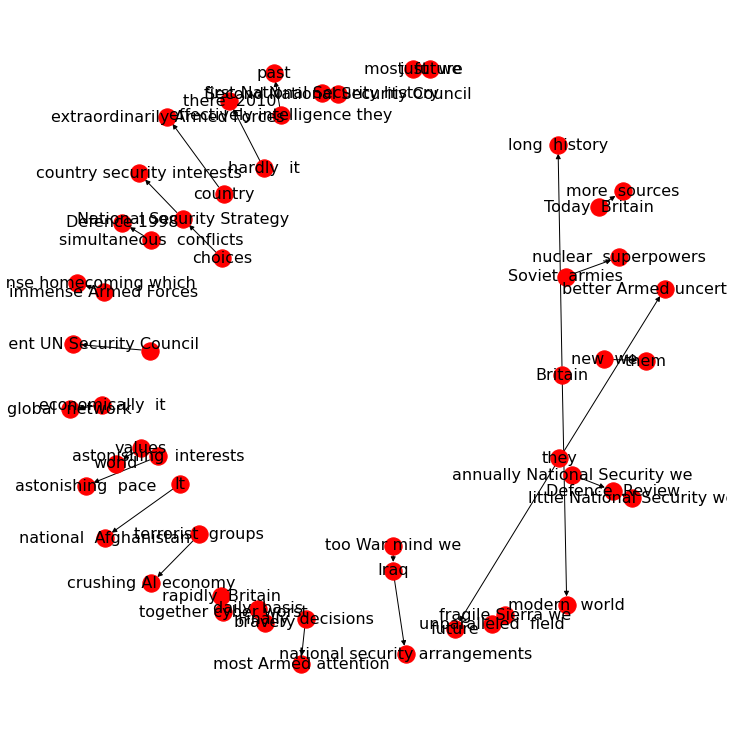

In [ ]:
plt.figure(figsize=(10,10))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos, font_size=16)
plt.show()

Creating subgraphs to segement on countries, events, organisations

Countries

100%|██████████| 18/18 [00:00<00:00, 96.70it/s] 


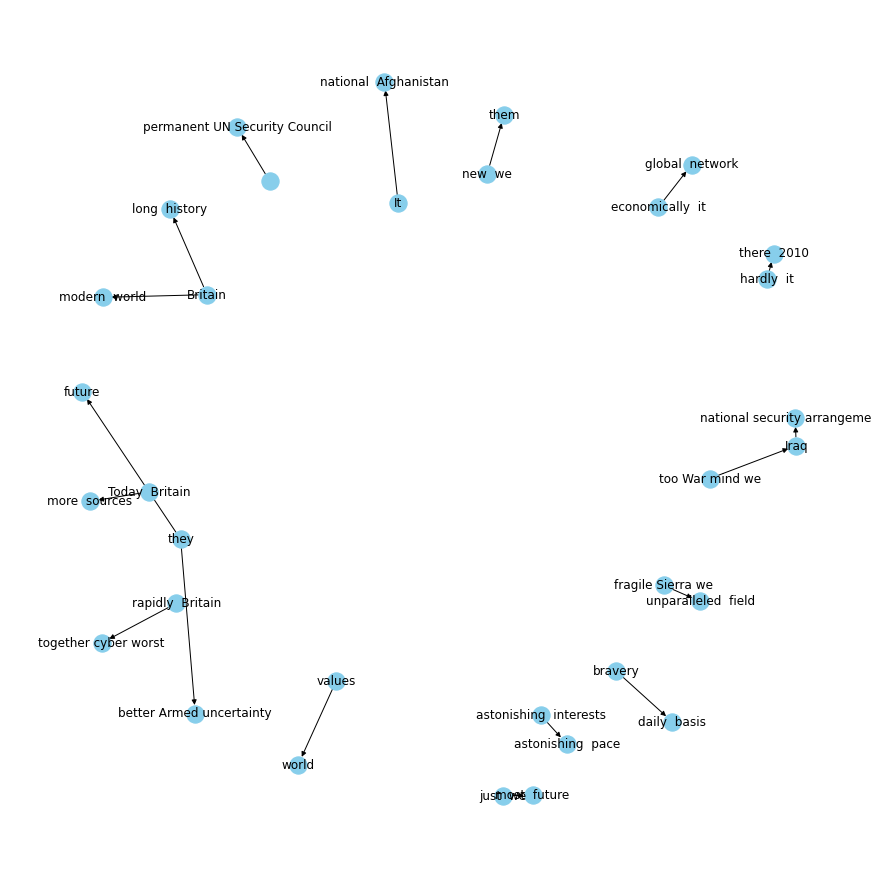

In [ ]:
# Segement data
keywords_2010_GPE = ['Britain', 'the United States of America', 'Afghanistan', 'Iraq']
searched_keywords_2010_GPE = '|'.join(keywords_2010_GPE)
# Filter
text_2010_filter_GPE = text_2010[text_2010["sentence"].str.contains(searched_keywords_2010_GPE)]
#text_2010_filter_GPE
# 18 sentences
# Get entity pairs
entity_pairs_2010_GPE = []

for i in tqdm(text_2010_filter_GPE["sentence"]):
  entity_pairs_2010_GPE.append(get_entities(i))

#entity_pairs_2010_GPE[10:20]
# Get relations
relations_2010_GPE = [get_relation(i) for i in tqdm(text_2010_filter_GPE['sentence'])]
tqdm._instances.clear()
# Subject
source_2010_GPE = [i[0] for i in entity_pairs_2010_GPE]
# Object
target_2010_GPE = [i[1] for i in entity_pairs_2010_GPE]
# Create df
kg_df_2010_GPE = pd.DataFrame({'source':source_2010_GPE, 'target':target_2010_GPE, 'edge':relations_2010_GPE})
# Create graph
G_2010_GPE =nx.from_pandas_edgelist(kg_df_2010_GPE, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
# Graph
pos = nx.spring_layout(G_2010_GPE)
nx.draw(G_2010_GPE, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Organisations

100%|██████████| 13/13 [00:00<00:00, 92.80it/s]


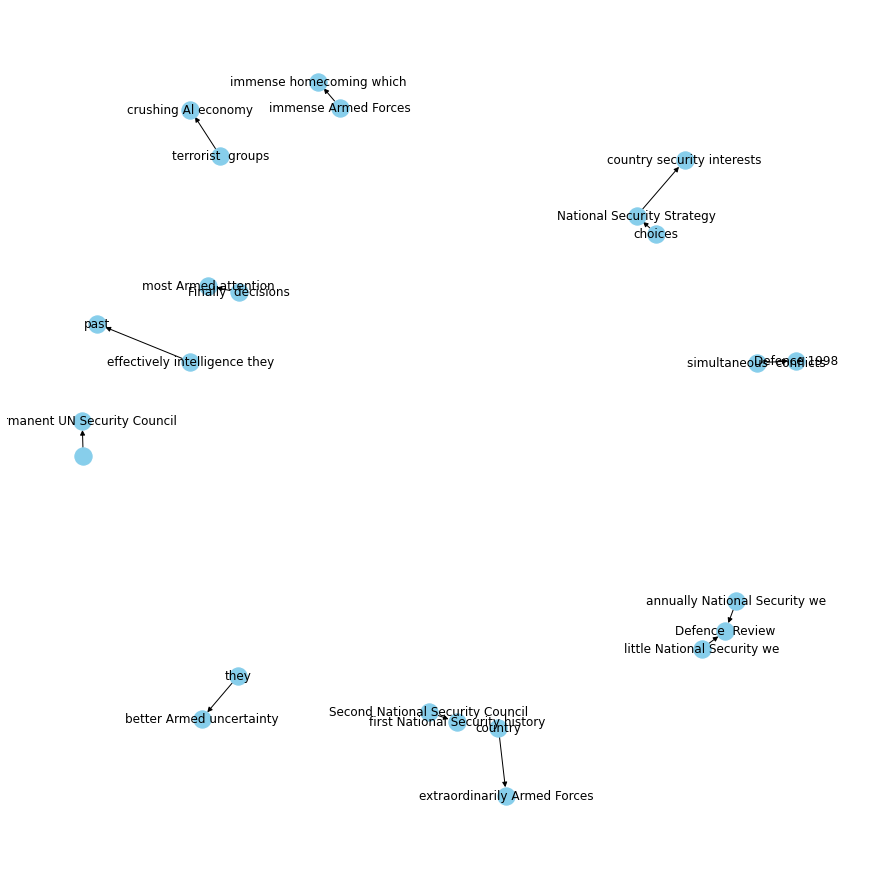

In [ ]:
# Keywords
keywords_2010_ORG = ['Al Qaeda','Armed Forces','National Security Strategy', 'the European Union', 'NATO', 'the UN Security Council','the Defence Review']
searched_keywords_2010_ORG = '|'.join(keywords_2010_ORG)
# Filter
text_2010_filter_ORG = text_2010[text_2010["sentence"].str.contains(searched_keywords_2010_ORG)]
text_2010_filter_ORG
# 13 sentences
# Get entity pairs
entity_pairs_2010_ORG = []

for i in tqdm(text_2010_filter_ORG["sentence"]):
  entity_pairs_2010_ORG.append(get_entities(i))

#entity_pairs_2010_ORG[10:20]
# Get relations
relations_2010_ORG = [get_relation(i) for i in tqdm(text_2010_filter_ORG['sentence'])]
tqdm._instances.clear()
# Subject
source_2010_ORG = [i[0] for i in entity_pairs_2010_ORG]
# Object
target_2010_ORG = [i[1] for i in entity_pairs_2010_ORG]
# Create df
kg_df_2010_ORG = pd.DataFrame({'source':source_2010_ORG, 'target':target_2010_ORG, 'edge':relations_2010_ORG})
# Create graph
G_2010_ORG =nx.from_pandas_edgelist(kg_df_2010_ORG, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
# Graph
pos = nx.spring_layout(G_2010_ORG)
nx.draw(G_2010_ORG, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Events

100%|██████████| 2/2 [00:00<00:00, 50.83it/s]


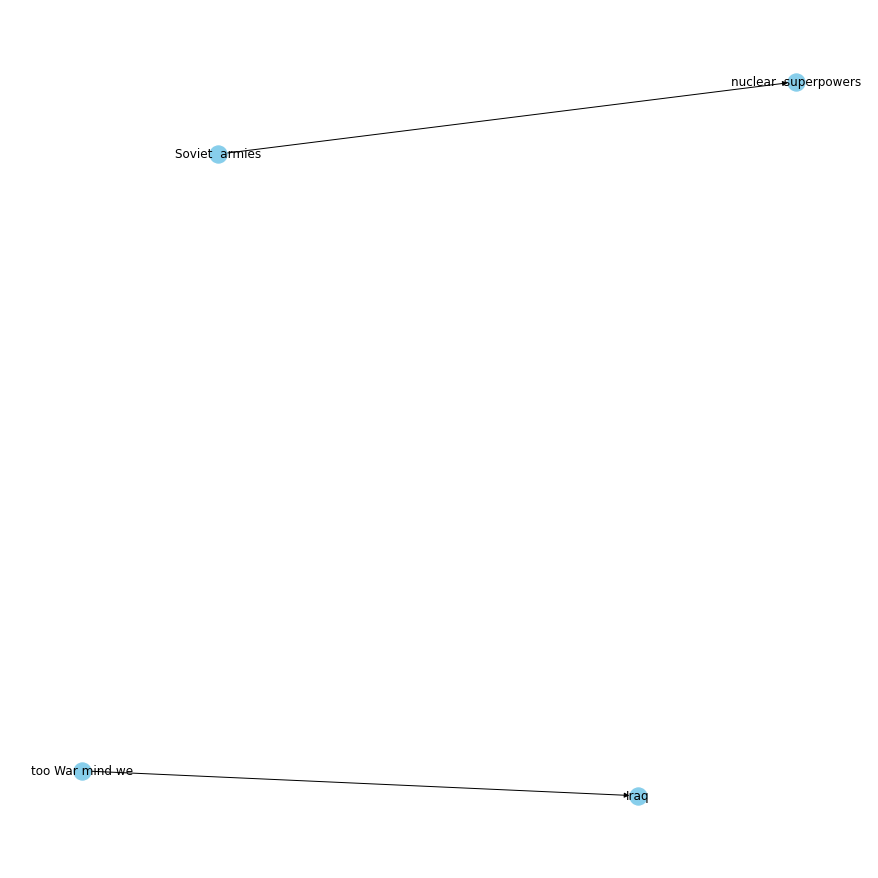

In [ ]:
# Keywords
keywords_2010_EVENT = ['Cold War']
searched_keywords_2010_EVENT = '|'.join(keywords_2010_EVENT)
# Filter
text_2010_filter_EVENT = text_2010[text_2010["sentence"].str.contains(searched_keywords_2010_EVENT)]
# text_2010_filter_EVENT
# 2 sentences
# Get entity pairs
entity_pairs_2010_EVENT = []

for i in tqdm(text_2010_filter_EVENT["sentence"]):
  entity_pairs_2010_EVENT.append(get_entities(i))

#entity_pairs_2010_ORG[10:20]
# Get relations
relations_2010_EVENT = [get_relation(i) for i in tqdm(text_2010_filter_EVENT['sentence'])]
tqdm._instances.clear()
# Subject
source_2010_EVENT = [i[0] for i in entity_pairs_2010_EVENT]
# Object
target_2010_EVENT = [i[1] for i in entity_pairs_2010_EVENT]
# Create df
kg_df_2010_EVENT = pd.DataFrame({'source':source_2010_EVENT, 'target':target_2010_EVENT, 'edge':relations_2010_EVENT})
# Create graph
G_2010_EVENT =nx.from_pandas_edgelist(kg_df_2010_EVENT, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
# Graph
pos = nx.spring_layout(G_2010_EVENT)
nx.draw(G_2010_EVENT, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()